In [2]:
import pandas as pd
import numpy as np 
import tweepy
import requests
import json
import os
import re
import matplotlib.pyplot as plt
import datetime
from timeit import default_timer as timer
from scipy import stats


# Gathering the data 

Firstly, read the manully downloaded WeRateDogs Twitter archive.

In [3]:
tweet_archive = pd.read_csv('twitter-archive-enhanced.csv')

Then, we programmatically download the tweet image predictions file. 

In [4]:
file_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(file_url)
with open (os.path.join(os.getcwd(), file_url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [5]:
tweet_predict = pd.read_csv('image-predictions.tsv', sep='\t')

Then, querying the twitter API to get each tweets JSON data, we will then save that JSON data to a text file.

In [11]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

deleted_tweets = []

tweet_ids = tweet_archiev.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [6]:
twt_id = []
faves = []
rts = []
with open('tweet_json.txt', mode='r') as f:
    for line in f.readlines():
        tweet_data = json.loads(line)
        twt_id.append(tweet_data['id'])
        faves.append(tweet_data['favorite_count'])
        rts.append(tweet_data['retweet_count'])

additional_tweets = pd.DataFrame({'tweet_id':twt_id, 'favorite_count':faves, 'retweet_count':rts})

#  Assessing the data 


In [7]:
tweet_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
tweet_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
tweet_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [10]:
tweet_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [11]:
tweet_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1647,683828599284170753,NaN,NaN,2016-01-04 01:53:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Breathtaking pupper here. Should be on the cov...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683828599...,12,10,None,None,None,pupper,None
65,879492040517615616,NaN,NaN,2017-06-27 00:10:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bailey. He thinks you should measure e...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879492040...,12,10,Bailey,None,None,None,None
1842,675870721063669760,6.757073e+17,4.196984e+09,2015-12-13 02:51:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",&amp; this is Yoshi. Another world record cont...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675870721...,11,10,None,None,None,None,None
28,886680336477933568,NaN,NaN,2017-07-16 20:14:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Derek. He's late for a dog meeting. 13...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886680336...,13,10,Derek,None,None,None,None
540,806542213899489280,NaN,NaN,2016-12-07 16:53:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Waffles. He's concerned that the dandr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806542213...,11,10,Waffles,None,None,None,None


In [12]:
print(tweet_archive[tweet_archive.tweet_id.isnull()])

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []


In [13]:
print(tweet_archive[tweet_archive.tweet_id.duplicated()])

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []


In [14]:
tweet_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
tweet_predict.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
tweet_predict.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
57,667073648344346624,https://pbs.twimg.com/media/CUHr8WbWEAEBPgf.jpg,1,Chihuahua,0.483682,True,pug,0.092494,True,Brabancon_griffon,0.057495,True
1115,724983749226668032,https://pbs.twimg.com/media/Cg-o3w0WgAANXdv.jpg,1,golden_retriever,0.675750,True,Great_Pyrenees,0.095168,True,cocker_spaniel,0.076043,True
1351,759846353224826880,https://pbs.twimg.com/media/CouEOZhWAAAgFpE.jpg,1,Sussex_spaniel,0.355395,True,vizsla,0.141094,True,otterhound,0.092198,True
787,690374419777196032,https://pbs.twimg.com/media/CZSz3vWXEAACElU.jpg,1,kuvasz,0.286345,True,Labrador_retriever,0.107144,True,ice_bear,0.085086,False
1441,775085132600442880,https://pbs.twimg.com/media/CsGnz64WYAEIDHJ.jpg,1,chow,0.316565,True,golden_retriever,0.241929,True,Pomeranian,0.157524,True


In [17]:
tweet_predict.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
web_site                      19
Cardigan                      19
beagle                        18
Shetland_sheepdog             18
Maltese_dog                   18
teddy                         18
Eskimo_dog                    18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

In [18]:
additional_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
tweet_id          2333 non-null int64
favorite_count    2333 non-null int64
retweet_count     2333 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [19]:
additional_tweets.describe()

,tweet_id,favorite_count,retweet_count
count,2.333000e+03,2333.000000,2333.000000
mean,7.419279e+17,7657.831976,2755.008144
std,6.820607e+16,11885.165311,4662.294572
min,6.660209e+17,0.000000,1.000000
25%,6.782786e+17,1330.000000,555.000000
50%,7.184547e+17,3336.000000,1291.000000
75%,7.986654e+17,9401.000000,3204.000000
max,8.924206e+17,158535.000000,79124.000000


In [20]:
additional_tweets.sample(5)

,tweet_id,favorite_count,retweet_count
2061,670807719151067136,1136,480
436,818614493328580609,10123,2664
1013,744995568523612160,3009,631
793,771102124360998913,6395,1476
396,822975315408461824,17741,3548


# Quality Issues


<b>tweet_archive:<b>
- In the 'name' column, some names are actually not real names.
- Wrong data type: 'tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'timestamp' and 'retweeted_status_timestamp'.
- Some expanded_urls are missing. 
- There are some 'rating_denominator' which are not 10.
- There are some 'rating_numerator' which are less than 10.
- Exclude any tweet that is a retweet.

<b>tweet_predict<b>
- Wrong data type: 'tweet_id'.

<b>additional_tweet<b>
- Wrong data type: 'tweet_id'.

# Tidiness Issues

<b>tweet_archive:<b>
- retweet columns not needed
- one variable in four columns (doggo, floofer, pupper, and puppo)

Then, three data frames tweet_archive, tweet_predict, and additional_tweets should be one (combined table) since all tables' entries are each describing one tweet.

# Cleaning

In [21]:
#Make copies from the original dataframes to clean dataframe

clean_tweet_archive = tweet_archive.copy()
clean_tweet_predict = tweet_predict.copy()
clean_additional_tweets = additional_tweets.copy()

<b>Fix the Quality issues<b>

<b>Define<b>

In the 'name' column, some names are actually not real names. The wrong names are either lower case or 'None'. Therefore, loop through the names and use the regex expression to further extract the name. The names which are not included in the tweet will be replaced by 'None'.

<b>Code<b>

In [22]:
wrong_names = []
for idx, name in enumerate(clean_tweet_archive.name):
    if name.islower() or name == 'None':
        j = re.compile('(?:named\s|name\sis\s)(\w+)')
        if j.findall(clean_tweet_archive.loc[idx,'text']):
            clean_tweet_archive.loc[idx,'name'] = j.findall(clean_tweet_archive.loc[idx,'text'])[0]
        else:
            clean_tweet_archive.loc[idx,'name'] = 'None'

<b>Test<b>

In [23]:
clean_tweet_archive.name.value_counts()

None          822
Charlie        12
Oliver         11
Lucy           11
Cooper         11
Tucker         10
Lola           10
Penny          10
Bo              9
Winston         9
Sadie           8
Daisy           7
Buddy           7
Toby            7
Bailey          7
Milo            6
Jax             6
Scout           6
Oscar           6
Koda            6
Stanley         6
Leo             6
Rusty           6
Dave            6
Bella           6
Jack            6
Alfie           5
Gus             5
Larry           5
Bentley         5
             ... 
Saydee          1
Ron             1
Tom             1
Crouton         1
Zoe             1
Sid             1
Rolf            1
Alphred         1
Chubbs          1
Brandonald      1
Sabertooth      1
Stu             1
Tyrus           1
Sweet           1
Enchilada       1
Brutus          1
Goliath         1
Willem          1
Mingus          1
Ginger          1
Naphaniel       1
Gerbald         1
Strider         1
Fabio           1
Arya      

<b>Define<b>

Wrong data type: 'tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'timestamp' and 'retweeted_status_timestamp'.
'tweet_id' should be string;
'timestamp' should be datatime;
The rest should be int64;

<b>Code<b>

In [24]:
clean_tweet_archive.tweet_id = clean_tweet_archive.tweet_id.astype('str')
clean_tweet_archive.timestamp = pd.to_datetime(clean_tweet_archive.timestamp)
#Since there are null values in the rest columns, we ignore them for now 

<b>Test<b>

In [25]:
clean_tweet_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

<b>Define<b>

Some expanded_urls are missing. Add the expanded_urls according to tweet_id row by row.

<b>Code<b>

In [26]:
def add_urls(row):
    if pd.notnull(row['expanded_urls']):
        return row
    else: 
        tweet_id = row['tweet_id']
        row['expanded_urls'] = 'https://twitter.com/dog_rates/status/{}'.format(tweet_id)
        return row
    
clean_tweet_archive = clean_tweet_archive.apply(add_urls, axis=1)

<b>Test<b>

In [27]:
clean_tweet_archive[clean_tweet_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<b>Define<b>

There are some 'rating_denominator' which are not 10. We check it row by row and assign 10 to it if it's not 10.

<b>Code<b>

In [28]:
clean_tweet_archive[clean_tweet_archive.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835246439...,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832088576...,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [29]:
def fix_denominator(row):
    if row['rating_denominator'] == 10:
        return row
    else: 
        row['rating_denominator'] = 10
        return row
    
clean_tweet_archive = clean_tweet_archive.apply(fix_denominator, axis=1)

<b>Test<b>

In [30]:
clean_tweet_archive[clean_tweet_archive.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<b>Define<b>

There are some 'rating_numerator' which are less than 10.

<b>Code<b>

In [31]:
clean_tweet_archive[clean_tweet_archive.rating_numerator < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
229,848212111729840128,NaN,NaN,2017-04-01 16:35:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's doing a distinguished tong...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/848212111...,6,10,Jerry,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/826598799...,7,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Herschel. He's slightly bi...,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409...,9,10,Beau,None,None,None,None
599,798682547630837760,NaN,NaN,2016-11-16 00:22:12,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here we see a rare pouched pupp...,6.769365e+17,4.196984e+09,2015-12-16 01:27:03 +0000,https://twitter.com/dog_rates/status/676936541...,8,10,None,None,None,pupper,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Not familiar with this breed. N...,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10,"<a href=""http://twitter.com/download/iphone"" r...",Who keeps sending in pictures without dogs in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781661882...,5,10,None,None,None,None,None
745,780092040432480260,NaN,NaN,2016-09-25 17:10:10,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Hank. He's mischievous ...,7.533757e+17,4.196984e+09,2016-07-13 23:48:51 +0000,https://twitter.com/dog_rates/status/753375668...,8,10,Hank,None,None,None,None


In [32]:
#since there are many of them, it's hard to check each one manully. We simply assgin 10 to them.
def fix_numerator(row):
    if row['rating_numerator'] >= 10:
        return row
    else: 
        row['rating_numerator'] = 10
        return row
    
clean_tweet_archive = clean_tweet_archive.apply(fix_numerator, axis=1)

<b>Test<b>

In [33]:
clean_tweet_archive[clean_tweet_archive.rating_numerator < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<b>Define<b>

Exclude any tweet that is a retweet. Find entries that are retweets by matching text pattern 'RT @' and drop entries from the table

<b>Code<b>

In [34]:
retweets = clean_tweet_archive.text.str.match('^RT @')
clean_tweet_archive = clean_tweet_archive[~retweets]

<b>Test<b>

In [35]:
retweets = clean_tweet_archive.text.str.match('^RT @')
clean_tweet_archive[retweets]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<b>Define<b>

The tweet_id in tweet_predict has wrong datatype. Convert it to string

<b>Code<b>

In [36]:
clean_tweet_predict.tweet_id = clean_tweet_predict.tweet_id.astype('str')

<b>Test<b>

In [37]:
clean_tweet_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


<b>Define<b>

The tweet_id in additional_tweet has wrong datatype. Convert it to string

<b>Code<b>

In [38]:
clean_additional_tweets.tweet_id = clean_additional_tweets.tweet_id.astype('str')

<b>Test<b>

In [39]:
clean_additional_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
tweet_id          2333 non-null object
favorite_count    2333 non-null int64
retweet_count     2333 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


<b>Fix the tidyness issues<b>

<b>Define<b>

One variable in four columns (doggo, floofer, pupper, and puppo). Make one column for dog stage (doggo, floofer, pupper, and puppo) by saving value ('None' if no dog stage given). Also record if there are multiple dog stages, separating by a comma.

<b>Code<b>

In [40]:
clean_tweet_archive['dog_stage'] = 'None'

def get_dog_stage(row):
    dog_stage = []

    if row['doggo'] == 'doggo':
        dog_stage.append('doggo')
    if row['floofer'] == 'floofer':
        dog_stage.append('floofer')
    if row['pupper'] == 'pupper':
        dog_stage.append('pupper')
    if row['puppo'] == 'puppo':
        dog_stage.append('puppo')
        
    if len(dog_stage) < 1: 
        row['dog_stage'] = 'None'
    else: 
        row['dog_stage'] = ','.join(dog_stage)
    return row

clean_tweet_archive = clean_tweet_archive.apply(get_dog_stage, axis=1)
clean_tweet_archive = clean_tweet_archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

<b>Test<b>

In [41]:
clean_tweet_archive.dog_stage.value_counts()

None             1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

<b>Define<b>

Drop retweet columns from each dataframe.

<b>Code<b>

In [42]:
retweet_columns = ['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
clean_tweet_archive.drop(retweet_columns, axis=1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


<b>Define<b>

three data frames tweet_archive, tweet_predict, and additional_tweets should be one (combined table) since all tables' entries are each describing one tweet.

<b>Code<b>

In [43]:
clean_tweet = pd.merge(clean_tweet_archive, clean_tweet_predict, how='left', on=['tweet_id'])
clean_additional_tweets.rename(columns={'id':'tweet_id'}, inplace=True)
clean_tweet_final = pd.merge(clean_tweet, clean_additional_tweets, how='left', on=['tweet_id'])



<b>Test<b>

In [44]:
clean_tweet_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 27 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 2175 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
dog_stage                     2175 non-null object
jpg_url                       1994 non-null object
img_num                       1994 non-null float64
p1                            1994 non-null object
p1_conf                    

# Storing

In [45]:
clean_tweet_final.to_csv('twitter_archive_master.csv')

# Analyzing and Visulizing

In [46]:
clean_tweet_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 27 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 2175 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
dog_stage                     2175 non-null object
jpg_url                       1994 non-null object
img_num                       1994 non-null float64
p1                            1994 non-null object
p1_conf                    

In [47]:
clean_tweet_final.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,favorite_count,retweet_count
count,7.800000e+01,7.800000e+01,0.0,0.0,0.0,2175.000000,2175.0,1994.000000,1994.000000,1.994000e+03,1.994000e+03,2168.000000,2168.000000
mean,7.455079e+17,2.014171e+16,NaN,NaN,NaN,13.776552,10.0,1.203109,0.593941,1.344195e-01,6.024848e-02,8240.646679,2487.639299
std,7.582492e+16,1.252797e+17,NaN,NaN,NaN,47.658424,0.0,0.560777,0.271954,1.006807e-01,5.089067e-02,12132.921700,4426.583480
min,6.658147e+17,1.185634e+07,NaN,NaN,NaN,10.000000,10.0,1.000000,0.044333,1.011300e-08,1.740170e-10,51.000000,1.000000
25%,6.757419e+17,3.086374e+08,NaN,NaN,NaN,10.000000,10.0,1.000000,0.362857,5.393988e-02,1.619283e-02,1753.250000,538.000000
50%,7.038708e+17,4.196984e+09,NaN,NaN,NaN,11.000000,10.0,1.000000,0.587635,1.174550e-01,4.950530e-02,3722.000000,1187.500000
75%,8.257804e+17,4.196984e+09,NaN,NaN,NaN,12.000000,10.0,1.000000,0.846285,1.951377e-01,9.159438e-02,10221.250000,2821.750000
max,8.862664e+17,8.405479e+17,NaN,NaN,NaN,1776.000000,10.0,4.000000,1.000000,4.880140e-01,2.734190e-01,158535.000000,79124.000000


In [48]:
clean_tweet_final.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
1565,679158373988876288,NaN,NaN,2015-12-22 04:35:49,"<a href=""http://twitter.com/download/iphone"" r...",This is Rubio. He has too much skin. 11/10 htt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679158373...,...,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False,21509.0,8107.0
245,838476387338051585,NaN,NaN,2017-03-05 19:48:43,"<a href=""http://twitter.com/download/iphone"" r...",This is Stanley. Somehow he heard you tell him...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838476387...,...,0.997692,True,kuvasz,0.001001,True,Newfoundland,0.000405,True,22833.0,4840.0
325,826848821049180160,NaN,NaN,2017-02-01 17:44:55,"<a href=""http://twitter.com/download/iphone"" r...",This is Cupid. He was found in the trash. Now ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826848821...,...,0.858764,True,golden_retriever,0.023526,True,Pekinese,0.017104,True,37195.0,10435.0
1221,699446877801091073,NaN,NaN,2016-02-16 04:15:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He's undercover in all these p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699446877...,...,0.969400,True,Cardigan,0.026059,True,Chihuahua,0.003505,True,6015.0,2648.0
1488,682662431982772225,NaN,NaN,2015-12-31 20:39:41,"<a href=""http://twitter.com/download/iphone"" r...",Meet Joey and Izzy. Joey only has one ear that...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682662431...,...,0.413824,True,Cardigan,0.263553,True,basset,0.167618,True,3100.0,1092.0


<b>Question<b>

What's the relationship between the number of favorites a tweet receives and its retweet number? 

<b>Code<b>

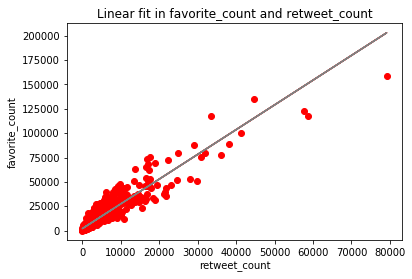

Line equation is: retweets = retweets = (2.541137111928492)*favorites + 1919.2141354580426
r value is: 0.9271102077955248


In [53]:
#Firstly, create a new df with only 'favorite_count' and 'retweet_count'
df_Q1 = clean_tweet_final[['favorite_count', 'retweet_count']] 
df_Q1 = df_Q1.dropna(subset=['favorite_count', 'retweet_count'])

#Then, fit all the data points with a linear line.
y, x = df_Q1.favorite_count, df_Q1.retweet_count
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope*x + intercept
plt.plot(x, y, 'o', x, line, color='red')
plt.plot(x, line, color='gray')
plt.title('Linear fit in favorite_count and retweet_count')
plt.xlabel('retweet_count')
plt.ylabel('favorite_count')
plt.show()

print('Line equation is: retweets = retweets = ({})*favorites + {}'.format(slope,intercept))
print('r value is: {}'.format(r_value))

<b>Analysis<b>

Although the relationship between favorite_count and retweet_count might be complicated and can't be simply described by linear line, it still gives us a good indication. The r_value is 0.927, which shows that the two variable are highly correlated. 

<b>Question<b>

To further study the relationship between favorite_count and retweet_count, we want to see does the dog which has the most favorite also have the most retweets? What does it look like?

<b>Code<b>

In [54]:
clean_tweet_final[clean_tweet_final['favorite_count'] == 158535.000000]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
862,744234799360020481,NaN,NaN,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744234799...,...,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,158535.0,79124.0


In [55]:
clean_tweet_final[clean_tweet_final['favorite_count'] == 158535.000000].jpg_url

862    https://pbs.twimg.com/ext_tw_video_thumb/74423...
Name: jpg_url, dtype: object

<b>Analysis<b>

Indeed, the dog which has the most favorite also have the most retweets.

<b>Question<b>

Which are the top 10 breeds? Compare the top 3 breeds' favorite_count.

<b>Code<b>

In [57]:
clean_tweet_final.p1.value_counts()[:10]

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
chow                   41
Samoyed                40
toy_poodle             38
Pomeranian             38
malamute               29
Name: p1, dtype: int64

Text(0,0.5,'breed')

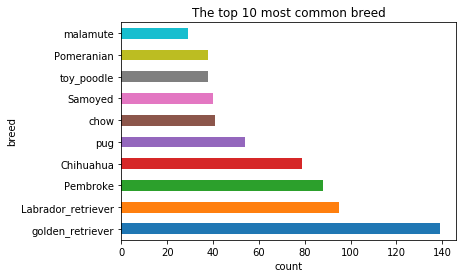

In [58]:
clean_tweet_final.p1.value_counts()[:10].plot(kind='barh')
plt.title('The top 10 most common breed')
plt.xlabel('count')
plt.ylabel('breed')

In [59]:
favorites_total_golden_retriever = clean_tweet_final.query('p1 == "golden_retriever"').favorite_count.sum()
favorites_total_Labrador_retriever = clean_tweet_final.query('p1 == "Labrador_retriever"').favorite_count.sum()
favorites_total_Pembroke = clean_tweet_final.query('p1 == "Pembroke"').favorite_count.sum()
print('total favorites of golden_retriever are {}'.format(favorites_total_golden_retriever))
print('total favorites of Labrador_retriever are {}'.format(favorites_total_Labrador_retriever))
print('total favorites of Pembroke are {}'.format(favorites_total_Pembroke))


total favorites of golden_retriever are 1601728.0
total favorites of Labrador_retriever are 1006600.0
total favorites of Pembroke are 941574.0
